In [82]:
import os
from collections import Counter
from itertools import product
from tqdm import tqdm
import torch
import torch.nn as nn
import math
import random
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

In [31]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [32]:


folder_path = 'dat410_europarl/'

translations = {}
file_list = os.listdir(folder_path)
text_files = [file for file in file_list]
for text_file in text_files:
    file_path = os.path.join(folder_path, text_file)
    with open(file_path, 'r', encoding='utf-8') as file:
        translations[file_path.split(".")[-1]] = [l[:-1] for l in file.readlines()]
        
translations["sv"]

['jag förklarar europaparlamentets session återupptagen efter avbrottet den 17 december . jag vill på nytt önska er ett gott nytt år och jag hoppas att ni haft en trevlig semester .',
 'som ni kunnat konstatera ägde &quot; den stora år 2000-buggen &quot; aldrig rum . däremot har invånarna i ett antal av våra medlemsländer drabbats av naturkatastrofer som verkligen varit förskräckliga .',
 'ni har begärt en debatt i ämnet under sammanträdesperiodens kommande dagar .',
 'till dess vill jag att vi , som ett antal kolleger begärt , håller en tyst minut för offren för bl.a. stormarna i de länder i europeiska unionen som drabbats .',
 'jag ber er resa er för en tyst minut .',
 'ni känner till från media att det skett en rad bombexplosioner och mord i sri lanka .',
 'en av de personer som mycket nyligen mördades i sri lanka var kumar ponnambalam , som besökte europaparlamentet för bara några månader sedan .',
 'skulle det vara möjligt för er , fru talman , att skriva ett brev till den srilank

In [33]:
simpel_translator = torch.load("simpel_translator.pth")

In [34]:
translator_dict = {}
for (swe_word, eng_word), prob in simpel_translator.items():
    eng_dict = translator_dict.get(eng_word, {})
    eng_dict[swe_word] = prob
    translator_dict[eng_word] = eng_dict


In [35]:

def simpel_translate_setance(sentence, translator_dict):
    out = []
    for word in sentence.split(" "):
        out.append(max(translator_dict[word], key=lambda k: translator_dict[word][k]))
    return " ".join(out)
sentence = "mrs lynne , you are quite right and i shall check whether this has actually not been done ."

simpel_translate_setance(sentence, translator_dict)

'. lynne , ni är helt rätt och jag kommer kontrollera om detta har verkligen inte har gjort .'

In [36]:
swe_count = Counter(" ".join(translations["sv"]).split(" "))
eng_count = Counter(" ".join(translations["en"]).split(" "))
print(swe_count.most_common(20))
print(eng_count.most_common(20))

[('.', 9648), ('att', 9181), (',', 8876), ('och', 7038), ('i', 5949), ('det', 5687), ('som', 5028), ('för', 4959), ('av', 4013), ('är', 3840), ('en', 3724), ('vi', 3211), ('jag', 3093), ('den', 2953), ('de', 2930), ('om', 2909), ('till', 2837), ('på', 2783), ('har', 2484), ('inte', 2385)]
[('the', 19322), (',', 13514), ('.', 9774), ('of', 9312), ('to', 8801), ('and', 6946), ('in', 6090), ('is', 4400), ('that', 4357), ('a', 4269), ('we', 3223), ('this', 3222), ('i', 2964), ('for', 2942), ('be', 2550), ('it', 2426), ('on', 2304), ('which', 2026), ('are', 1917), ('have', 1881)]


In [37]:
eng_vocab = [t[0] for t in eng_count.most_common()]
eng_vocab = ["<UKN>", "<PAD>", "<s>", "</s>"] + eng_vocab[:int(len(eng_vocab) * 0.30)]
print("Portion of unknow english words in the corpus", 1 -sum([eng_count[w] for w in eng_vocab]) / sum(eng_count.values()))
print("Length of vocab",  len(eng_vocab))

Portion of unknow english words in the corpus 0.051372053034717036
Length of vocab 3334


In [38]:
eng_id2word = {i:w for i, w in enumerate(eng_vocab)}
eng_word2id = {w:i for i, w in enumerate(eng_vocab)}

In [39]:
#Transalte wprds in to ids, with start and end tokens at respective ends
eng_tokens = [[2] + [eng_word2id.get(w, 0) for w in scent.split(" ")] + [3] for scent in  translations["en"]]
max_len = max([len(ids) for ids in eng_tokens])
#Add padding such that all scentances are of equal length
eng_tokens = [scent + [1] * (max_len - len(scent)) for scent in eng_tokens]
#Assert that they are of equal length
assert all([len(ids) == len(eng_tokens[0]) for ids in eng_tokens])
eng_tokens, len(eng_tokens), len(eng_tokens[0])

([[2,
   16,
   2987,
   2737,
   4,
   2043,
   7,
   4,
   29,
   49,
   0,
   20,
   2338,
   2181,
   1030,
   243,
   5,
   9,
   16,
   34,
   54,
   288,
   225,
   8,
   388,
   41,
   13,
   1153,
   82,
   260,
   10,
   4,
   217,
   12,
   41,
   0,
   13,
   0,
   0,
   342,
   6,
   3,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   

In [40]:
swe_vocab = [t[0] for t in swe_count.most_common()]
swe_vocab = ["<UKN>", "<PAD>", "<s>", "</s>"] + swe_vocab[:int(len(swe_vocab) * 0.35)]
print("Portion of unknow swedish words in the corpus", 1 -sum([swe_count[w] for w in swe_vocab]) / sum(swe_count.values()))
print("Length of vocab",  len(swe_vocab))

Portion of unknow swedish words in the corpus 0.05783098983711543
Length of vocab 6441


In [41]:
swe_id2word = {i:w for i, w in enumerate(swe_vocab)}
swe_word2id = {w:i for i, w in enumerate(swe_vocab)}

In [42]:
#Transalte wprds in to ids, with start and end tokens at respective ends
swe_tokens = [[2] + [swe_word2id.get(w, 0) for w in scent.split(" ")] + [3] for scent in  translations["sv"]]
max_len = max([len(ids) for ids in swe_tokens])
#Add padding such that all scentances are of equal length
swe_tokens = [scent + [1] * (max_len - len(scent)) for scent in swe_tokens]
#Assert that they are of equal length
assert all([len(ids) == len(swe_tokens[0]) for ids in swe_tokens])
swe_tokens, len(swe_tokens), len(swe_tokens[0])

([[2,
   16,
   1553,
   424,
   3535,
   4943,
   127,
   4141,
   17,
   2101,
   969,
   4,
   16,
   37,
   21,
   311,
   2102,
   94,
   25,
   913,
   311,
   99,
   7,
   16,
   183,
   5,
   53,
   508,
   14,
   6285,
   6286,
   4,
   3,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
 

In [43]:
def random_split_list(input_list, split_ratio):
    assert 0 <= split_ratio <= 1, "Split ratio must be between 0 and 1"

    values = input_list.copy()
    random.shuffle(values)

    split_index = int(len(values) * split_ratio)
    first_list = values[:split_index]
    second_list = values[split_index:]

    return first_list, second_list

In [44]:
train_indecies, rest = random_split_list(list(range(len(eng_tokens))), 0.7)
val_indecies, test_indecies= random_split_list(rest, 0.5)
assert len(train_indecies) + len(val_indecies) + len(test_indecies) == len(eng_tokens)
assert sorted(train_indecies + val_indecies + test_indecies) == list(range(len(eng_tokens)))
train_indecies[:10], val_indecies[:10], test_indecies[:10]

([5239, 3396, 3570, 6623, 3477, 5525, 9647, 4181, 6177, 1783],
 [9629, 5221, 1538, 3696, 8302, 8315, 5795, 3244, 1733, 8218],
 [7732, 2356, 5149, 4755, 3305, 587, 9318, 9042, 7744, 2972])

In [45]:
train_eng = torch.tensor(eng_tokens)[train_indecies]
train_swe = torch.tensor(swe_tokens)[train_indecies]

val_eng = torch.tensor(eng_tokens)[val_indecies]
val_swe = torch.tensor(swe_tokens)[val_indecies]

test_eng = torch.tensor(eng_tokens)[test_indecies]
test_swe = torch.tensor(swe_tokens)[test_indecies]

assert train_eng.shape[0] + val_eng.shape[0] + test_eng.shape[0] == len(eng_tokens)
train_eng.shape

torch.Size([7000, 187])

In [46]:
class TextEncoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, output_size, dropout_prob):
        super(TextEncoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout_prob)
        self.linear = nn.Linear(hidden_dim * num_layers, output_size)

    def forward(self, input_text):
        embedded_text = self.embedding(input_text)
        lstm_out, (hiddens, _) = self.lstm(embedded_text)
        concat_hiddens = hiddens.permute(1, 0, 2).flatten(start_dim=1)
        output = self.linear(concat_hiddens)  # Apply linear layer
        return output
    
class TextDecoder(nn.Module):
    def __init__(self, vocab_size, hidden_size, encoding_size):
        super(TextDecoder, self).__init__()
        self.hidden_size = hidden_size
        self.encoding_size = encoding_size
        
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.rnn = nn.LSTM(hidden_size + encoding_size, hidden_size)# Concatenated input size: hidden_size + encoding_size
        self.out = nn.Linear(hidden_size, vocab_size)
        self.softmax = nn.LogSoftmax(dim=2)  # Change softmax dimension to 2

    def forward(self, encoding, input, hidden = None):
        #if hidden == None:
            #hidden = torch.zeros((input.shape[0], self.hidden_size))

       
        seq_len = input.size(1)
        
        # Repeat encoding along the sequence dimension
        repeated_encoding = encoding.unsqueeze(1).repeat(1, seq_len, 1)
        
        # Embed the input tokens
        embedded_input = self.embedding(input)
        
        # Concatenate embedding with encoding
        concatenated_input = torch.cat((embedded_input, repeated_encoding), dim=2)
        
        # Pass through RNN
        if hidden != None:
            output, hidden = self.rnn(concatenated_input, hidden)
        else:
            output, hidden = self.rnn(concatenated_input)
        
        # Compute output probabilities
        output = self.softmax(self.out(output))
        
        return output, hidden

In [78]:
eng_vocab_size = len(eng_vocab)
encoder_embedding_dim = 128
encoder_hidden_dim = 256
encoder_num_layers = 2 
encoder_dropout_prob = 0.2

encoder_encoding_size = 128 

swe_vocab_size= len(swe_vocab)
decoder_hiden_size = 256



num_epochs = 2
batch_size = 16
encoder_learning_rate = 0.01
decoder_learning_rate = encoder_learning_rate

In [79]:
tensor = torch.tensor([[1, 2, 3],
                        [4, 5, 6],
                        [7, 8, 9]])
print(tensor.sum(dim = 1))

tensor([ 6, 15, 24])


In [84]:
model_name = "model1.pth"


if not os.path.exists(model_name):
    encoder = TextEncoder(eng_vocab_size, encoder_embedding_dim, encoder_hidden_dim, encoder_num_layers, encoder_encoding_size, encoder_dropout_prob)
    decoder = TextDecoder(swe_vocab_size, decoder_hiden_size, encoder_encoding_size)
    encoder.to(device)
    decoder.to(device)

    train_loader = DataLoader(TensorDataset(train_eng, train_swe), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(val_eng, val_swe), batch_size=batch_size, shuffle=True)
    encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=encoder_learning_rate)
    decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=decoder_learning_rate)
    loss_function = nn.CrossEntropyLoss()
    #progress = tqdm(total=num_epochs * (len(train_loader) / batch_size + len(val_loader) / batch_size + 2))

    train_losses = []
    val_losses = []
    for epoch in tqdm(range(num_epochs)):
        total_loss = 0
        num_batches = 0
        
        for eng_text, swe_text in (train_loader):
            

            indecies = torch.where((eng_text == 1).sum(dim =0) == batch_size)[0]
            first_pad_eng = indecies[0].item() if indecies.shape[0] != 0 else eng_text.shape[1]
            eng_text = eng_text[:, :first_pad_eng].to(device)
            indecies = torch.where((swe_text == 1).sum(dim =0) == batch_size)[0]
            first_pad_swe = indecies[0].item() if indecies.shape[0] != 0 else swe_text.shape[1]
            swe_text = swe_text[:, :first_pad_swe].to(device)

            
            encoding = encoder(eng_text)
            decoding,_ = decoder(encoding, swe_text[:,:-1]) #should not ptrdict continuations

            ground_truth = F.one_hot(swe_text[:,1:], swe_vocab_size).float()
            loss = loss_function(ground_truth, decoding)

            encoder_optimizer.zero_grad()
            decoder_optimizer.zero_grad()
            loss.backward()
            encoder_optimizer.step()
            decoder_optimizer.step()
            train_losses.append(loss)


        for eng_text, swe_text in (val_loader):
            indecies = torch.where((eng_text == 1).sum(dim =0) == batch_size)[0]
            first_pad_eng = indecies[0].item() if indecies.shape[0] != 0 else eng_text.shape[1]
            eng_text = eng_text[:, :first_pad_eng].to(device)
            indecies = torch.where((swe_text == 1).sum(dim =0) == batch_size)[0]
            first_pad_swe = indecies[0].item() if indecies.shape[0] != 0 else swe_text.shape[1]
            swe_text = swe_text[:, :first_pad_swe].to(device)

            encoding = encoder(eng_text)
            decoding,_ = decoder(encoding, swe_text[:,:-1])#should not ptrdict continuations
            ground_truth = F.one_hot(swe_text[:,1:], swe_vocab_size).float()
            loss = loss_function(ground_truth, decoding)
            val_losses.append(loss)

    torch.save({"encoder": encoder, 
                "decoder": decoder, 
                "train_losses": train_losses,
                "val_losses": val_losses},
                model_name)

In [90]:
model_dict = torch.load(model_name)
train_losses =[a.item() for a in model_dict["train_losses"]]
val_losses = [a.item() for a in model_dict["val_losses"]]

In [91]:
len(train_losses), len(val_losses)

(876, 188)

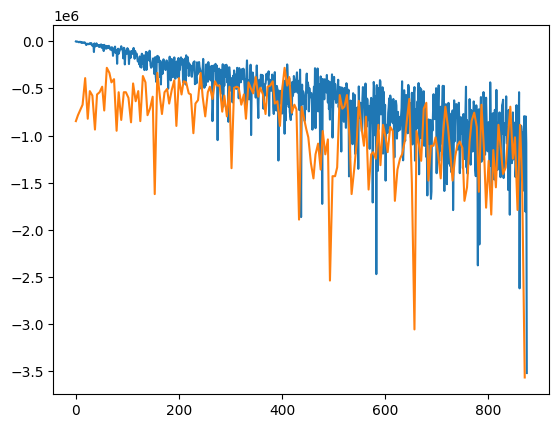

In [97]:
plt.plot(range(len(train_losses)), train_losses)
x = [int(a * len(train_losses) / len(val_losses)) for a in range(len(val_losses))]
plt.plot(x, val_losses)
plt.show()